In this notebook, I aim to roll through an analysis across a single patient which can easily be looped for multiple patients. To do so, we will use the functions that are written out more explicitly in the step-by-step notebooks. 

**This is the one you should copy and edit for your own actual analyses**

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

## Load, pre-process and re-reference the neural data

In [9]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results  
subj_ids = ['MS012', 'MS025']
# My task has multiple days. Yours probably does not. So you can remove this inner loop in the following cells.
days = ['Day1']
subj_formats = ['edf', 'edf']
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference to a proximal white matter electrode (or bipolar, if desired) 

In [10]:
for ix, subj_id in enumerate(subj_ids): 
    for day in ['Day1']:
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
        # electrode files could either be csv or excel
        elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
        # There should really only be one 
        elec_file = elec_files[0]
        save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
        
        # Check if path exists for saving, and if not, make it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Load electrode data (should already be manually localized!)
        if elec_file.split('.')[-1] =='csv':
            elec_data = pd.read_csv(elec_file)
        elif elec_file.split('.')[-1] =='xlsx': 
            elec_data = pd.read_excel(elec_file)

        # Sometimes there's extra columns with no entries: 
        elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_data=elec_data, 
                                                 format=subj_formats[ix],
                                                 return_data=True)

        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                      elec_data=elec_data, 
                                                      method='wm', 
                                                      site='MSSM')

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/wm_ref_ieeg.fif', overwrite=True)
        


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:697: UserWarning: No photodiode channel specified - please check /sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif to make sure a valid sync signal was saved
  warnings.warn(f'No photodiode channel specified - please check {load_path}/photodiode.fif to make sure a valid sync signal was saved')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:735: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=photodiode_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

If you have ran the preprocessing above, load the data instead: 


In [11]:
for subj_id in subj_ids: 
    for day in ['Day1']:
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
        elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
        # There should really only be one 
        elec_file = elec_files[0]
        save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

        # Load electrode data (should already be manually localized!)
        if elec_file.split('.')[-1] =='csv':
            elec_data = pd.read_csv(elec_file)
        elif elec_file.split('.')[-1] =='xlsx': 
            elec_data = pd.read_excel(elec_file)

        # Sometimes there's extra columns with no entries: 
        elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/wm_ref_ieeg.fif', preload=True)

        photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

        # Append to list 
        mne_dict[subj_id][day].append(mne_data_reref)

        photodiode_dict[subj_id][day].append(photodiode_data)

        elec_dict[subj_id][day].append(elec_data)

/tmp/ipykernel_105669/2060006756.py:22: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_105669/2060006756.py:22: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS025/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)


## Sync behavioral and neural data

In [12]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

for subj_id in subj_ids: 
    for day in ['Day1']:
        
        # Load the behavioral timestamps: 
        
        behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
        temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
        beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
        beh_ts = beh_ts[~np.isnan(beh_ts)] 
        
        # Synchronize to the photodiode or whatever your neural sync signal is
        slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                    photodiode_dict[subj_id][day][0], 
                                                    smoothSize=11, windSize=15, height=1)

        slopes[subj_id][day].append(slope)
        offsets[subj_id][day].append(offset)


28 blocks
............................

found matches for 180 of 428 pulses
31 blocks
...............................

found matches for 300 of 469 pulses


## Load your behavioral data

You probably have a separate notebook for processing the behavioral data for your task. Load the processed dataframe here:

In [59]:
behav_data = pd.read_csv(f'{base_dir}/work/qasims01/MemoryBanditData/EMU/learn_df.csv')

In [60]:
# Filter just to the participants in this notebook
behav_data = behav_data[behav_data.participant.isin(subj_ids)]

## Make epochs

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback. Note I also segment a baseline period for every event of interest. I will compute everything I do on both epochs, and subtract the baseline from the event epoch

In [57]:
behav_data[['feedback_start', 'baseline_start']]

,feedback_start,baseline_start
0,243.239158,244.929025
1,248.344187,250.043187
2,254.083059,255.790670
3,258.148220,259.838892
4,261.943712,263.620631
...,...,...
955,595.294837,597.019395
956,599.172800,600.900948
957,603.263902,604.999053
958,609.226880,610.946418


I'm a little dumb, so my baseline is a fixation cross AFTER the trial, rather than before. A bit silly if you ask me. 

In [76]:
# set some windows of interest 

IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

# Note: I am treating the baseline events just like ANY OTHER event

# add behavioral times of interest 
for subj_id in subj_ids:
    for day in ['Day1']:
        # Filter behavior to the specific subject
        subj_data = behav_data[behav_data.participant==subj_id]
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
        
        epochs_all_evs = {f'{x}': np.nan for x in evs}
        epochs_all_baseline = {f'{x}': np.nan for x in evs}

        for event in evs.keys():
            ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/wm_ref_ieeg.fif', 
                         elec_data=elec_dict[subj_id][day][0], 
                         slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0],
                         behav_name=event, behav_times=subj_data[event].values, 
                         ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                         downsamp_factor=2, IED_args=IED_args)

            epochs_all_evs[event] = ev_epochs
            epochs_all_evs[event].save(f'{save_path}/epoch_{event}.fif', overwrite=True)

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1044: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3686 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4477 out of 4480 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.0s finished
/tmp/ipykernel_105669/3079971829.py:34: RuntimeWarning: Thi

# Descriptive analyses:

Here we are mostly going to make a lot of spectral plots and things to look over manually as a function of event timing, without getting into the more advanced GLM stuff. 

In [220]:
# Load the data 
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}
epochs_all_subjs_all_evs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

for subj_id in subj_ids:
    # Filter behavior to the specific subject
    subj_data = behav_data[behav_data.participant==subj_id]
    for event in evs.keys():
        load_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
        ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
        
        epochs_all_subjs_all_evs[subj_id][event] = ev_epochs
        
        # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

        event_metadata = epochs_all_subjs_all_evs[subj_id][event].metadata.copy()

        event_metadata['rt'] = subj_data['gamble_rt'].tolist()
        event_metadata['reward'] = subj_data['reward'].tolist()
        event_metadata['image_dprime'] = subj_data['DPRIME'].tolist()
        event_metadata['rpe'] = subj_data['rpe'].tolist()

        epochs_all_subjs_all_evs[subj_id][event].metadata = event_metadata
    

/tmp/ipykernel_105669/3347424550.py:11: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS012/neural/Day1/epoch_feedback_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
/tmp/ipykernel_105669/3347424550.py:11: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS012/neural/Day1/epoch_baseline_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{load_path}/epoch_{event}.fif', preload=True)
/tmp/ipykernel_105669/3347424550.py:11: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS025/neural/Day1/epoch_feedback_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -e

In [222]:
epochs_all_subjs_all_evs['MS025']['feedback_start']

Number of events,80
Events,feedback_start: 80
Time range,-1.000 – 2.500 sec
Baseline,off


In [223]:
epochs_all_subjs_all_evs['MS025']['baseline_start']

Number of events,80
Events,baseline_start: 80
Time range,-1.000 – 1.748 sec
Baseline,off


Plot and examine the epochs if you'd like

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach.

Goals: 
- Plot the FOOOF results 
- Collect the FOOOF parameters 
- Subtract the 1/f 
- Save/return the corrected PSDs (and overlay plot them) 


In [513]:
# Get electrode df 
elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
elec_files = glob(f'{elec_path}/*labels.csv')[0]
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'

# Load electrode data (should already be manually localized!)
elec_data = pd.read_csv(elec_files)

# Sometimes there's extra columns with no entries: 
elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names

/tmp/ipykernel_123865/3941998125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names


In [ ]:
# Code to specify how to deal with roi inputs:



Running FOOOFGroup across 9 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 9 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 5 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 5 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 7 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 7 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 15 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 15 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 23 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 23 power spectra.


/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


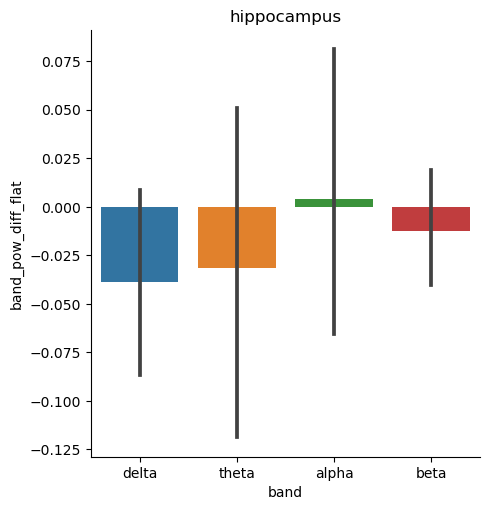

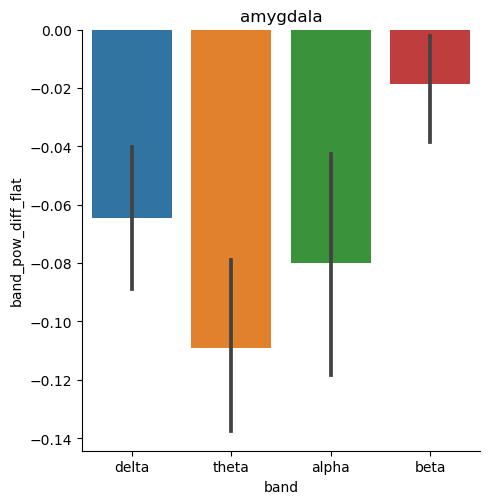

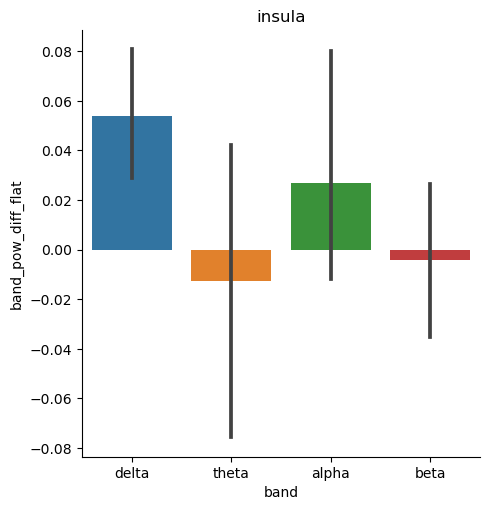

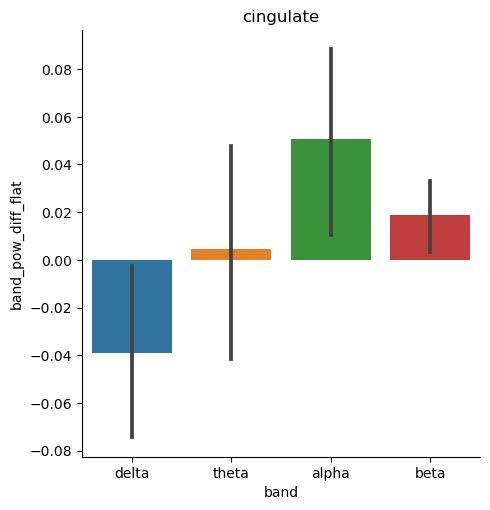

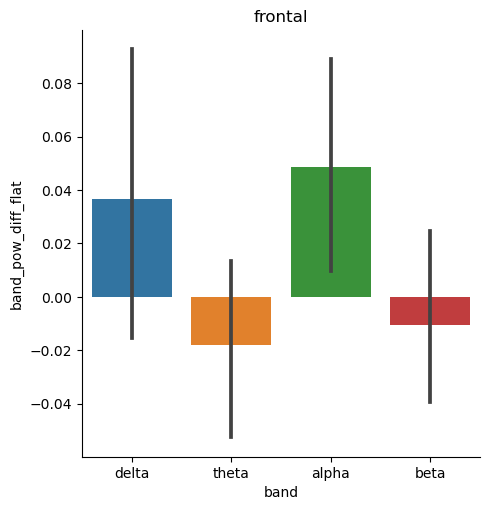

In [518]:
tmin = 0
tmax = 1.5

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 6,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}


# Use the metadata to parse the epochs before computing anything

rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']
conditions = ['reward==1', 'reward==0']
group_rois = False 

for subj_id in subj_ids:
    
    for event in evs:    
        filepath = f'/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/scratch/FOOOF/{event}'
        for region in rois: 
            
            filepath = f'{filepath}/region'    
            # If the path doesn't exist, make it:
            if not os.path.exists(file_path): 
                os.makedirs(file_path)
            
            # sub-select channels and make directories if need be 
            picks = analysis_utils.select_picks_rois(elec_df, region)
        
            # sub-select epochs 
            chan_epochs = epochs_all_subjs_all_evs[subj_id][event].copy().pick_channels(picks)

            compare_df = FOOOF_compare_epochs(chan_epochs, tmin=tmin, tmax=tmax, 
                                              conditions=conditions, band_dict=band_dict, 
                                              file_path=filepath, plot=True, **FOOOF_kwargs)
            

In [557]:
#    #         picks.append(elec_data[elec_data.YBA_1.str.lower().str.contains(region)].label.tolist())

#     #         epo_spectrum_list = [epochs.compute_psd(method='multitaper',
#     #                                             tmin=tmin,
#     #                                             tmax=tmax, 
#     #                                             picks=elecs) for elecs in picks]

#     #         for epo_spectrum in epo_spectrum_list:
#     #             psds, freqs = epo_spectrum.get_data(return_freqs=True)
#     #             # average across epochs
#     #             psd_trial_avg = np.average(psds, axis=0) 
#     #             # average across epochs
#     #             psd_trial_avg = np.average(psds, axis=0) 

#     #             # Initialize a FOOOFGroup object, with desired settings
#     #             fg = FOOOFGroup(peak_width_limits=kwargs['peak_width_limits'], 
#     #                             min_peak_height=kwargs['min_peak_height'],
#     #                             peak_threshold=kwargs['peak_threshold'], 
#     #                             max_n_peaks=kwargs['max_n_peaks'], 
#     #                             verbose=False)

#     #             # Fit the FOOOF object 
#     #             fg.fit(freqs, psd_trial_avg, kwargs['freq_range'])

#     #             FOOOFGroup_res.append(fg)

#     # # select the electrodes in the roi
#     # elif isinstance(roi, str): 
#     #     filepath = f'{filepath}/region'    
#     #     # If the path doesn't exist, make it:
#     #     if not os.path.exists(file_path): 
#     #         os.makedirs(file_path)
#     #     picks = elec_data[elec_data.YBA_1.str.lower().str.contains(region)].label.tolist()

#     # elif roi is None: 
#     #     picks = elec_data.label.tolist()
        
#         for region in rois: 
#             # sub-select channels: 
# #             picks = elec_df[elec_df.YBA_1.str.lower().str.contains('|'.join(region))].label.tolist()
#             picks = elec_df[elec_df.YBA_1.str.lower().str.contains(region)].label.tolist()

#             all_chan_dfs = []
            
#             for parsing in data_parsing: 

#                 # check that this is an appropriate parsing (is it in the metadata?)
#                 try:
#                     epochs_all_subjs_all_evs[subj_id][event].metadata.query(parsing)
#                 except pd.errors.UndefinedVariableError:
#                     raise KeyError(f'FAILED: the {parsing} condition is missing from epoch.metadata')


#                 # If the path doesn't exist, make it:
#                 if not os.path.exists(file_path): 
#                     os.makedirs(file_path)

#                 file_name = f'group_{parsing}'

#                 epo_spectrum = epochs[parsing].compute_psd(method='multitaper',
#                                                                     fmax=fmax,
#                                                                     tmin=tmin,
#                                                                     tmax=tmax, 
#                                                                     picks=picks)
                
#                 psds, freqs = epo_spectrum.get_data(return_freqs=True)

#                 # average across epochs
#                 psd_trial_avg = np.average(psds, axis=0)  # (3, 513)


#                 # Initialize a FOOOFGroup object, with desired settings
#                 fg = FOOOFGroup(peak_width_limits=peak_width_limits, 
#                                 min_peak_height=min_peak_height,
#                                 peak_threshold=peak_threshold, 
#                                 max_n_peaks=max_n_peaks, 
#                                 verbose=True)

#                 fg.fit(freqs, psd_trial_avg, freq_range)

#                 fooof_groups[parsing] = fg

#                 # Check the overall results of the group fits
#                 fg.save_report(file_name=file_name,
#                               file_path=file_path)

#             # Check the overall results for each channel split by condition 

#             for chan in range(psd_trial_avg.shape[0]):
#                 file_name = f'{epo_spectrum.ch_names[chan]}_PSD.pdf'

#     #                 fm.save_report(file_name=file_name,
#     #                       file_path=file_path)

#                 cond_fits = [fooof_groups[parsing].get_fooof(ind=chan, regenerate=True) for parsing in data_parsing]
#                 for i in range(len(cond_fits)):
#                     cond_fits[i].fit()

#                 save_file = f'{file_path}/{file_name}'

#                 chan_data_df = pd.DataFrame(columns=['exp_diff', 'peak_pow_diff', 'band_pow_diff', 'band_pow_diff_flat', 'band'])

#                 exp_diff = compare_exp(cond_fits[0], cond_fits[1])

#                 band_labels = []
#                 peak_pow_diffs = [] 
#                 band_pow_diffs = []
#                 band_pow_diff_flats = []


#                 for label, definition in bands:
#                     band_labels.append(label)
#                     peak_pow_diffs.append(compare_peak_pw(cond_fits[0], cond_fits[1], definition))
#                     band_pow_diffs.append(compare_band_pw(cond_fits[0], cond_fits[1], definition))
#                     band_pow_diff_flats.append(compare_band_pw_flat(cond_fits[0], cond_fits[1], definition))

#                 chan_data_df['peak_pow_diff'] = peak_pow_diffs
#                 chan_data_df['band_pow_diff'] = band_pow_diffs
#                 chan_data_df['band_pow_diff_flat'] = band_pow_diff_flats
#                 chan_data_df['band'] = band_labels
#                 chan_data_df['exp_diff'] = exp_diff
#                 chan_data_df['channel'] = epo_spectrum.ch_names[chan]
#                 chan_data_df['event'] = event

#                 all_chan_dfs.append(chan_data_df)

#                 with PdfPages(save_file) as pdf:

#                     f, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=300)

#                     # Plot the power spectra differences, representing the 'band-by-band' idea
#                     fooof.plts.spectra.plot_spectra_shading(fm.freqs, 
#                                                             [x.power_spectrum for x in cond_fits],
#                                                             log_powers=False, linewidth=3,
#                                                             shades=bands.definitions, shade_colors=shade_cols,
#                                                             labels=data_parsing,
#                                                             ax=ax[0])
#                     ax[0].set_title(f'{epo_spectrum.ch_names[chan]}', t_settings);

#                     # Plot the flattened power spectra differences
#                     fooof.plts.spectra.plot_spectra_shading(fm.freqs, 
#                                                             [x._spectrum_flat for x in cond_fits],
#                                                             log_powers=False, linewidth=3,
#                                                             shades=bands.definitions, shade_colors=shade_cols,
#                                                             labels=data_parsing,
#                                                             ax=ax[1])
#                     ax[1].set_title(f'{epo_spectrum.ch_names[chan]} - flattened ', t_settings);

#                     f.tight_layout()

#                     pdf.savefig()
#                     plt.close(f)
                    
# #             all_chan_dfs = pd.concat(all_chan_dfs)
# #             sns.catplot(data=all_chan_dfs, x='band', y='band_pow_diff_flat', kind='bar')
# #             plt.title(f'{region}')
#             # Save out the FOOOF objects
#             joblib.dump(fooof_groups, f'{file_path}/FOOOF_objects.py')

In [505]:
elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
elec_files = glob(f'{elec_path}/*labels.csv')[0]
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'

# Load electrode data (should already be manually localized!)
elec_data = pd.read_csv(elec_files)

# Sometimes there's extra columns with no entries: 
elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

anode_list = [x.split('-')[0] for x in epo_spectrum.ch_names]
elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
elec_df['label'] = epo_spectrum.ch_names

/tmp/ipykernel_123865/4128493782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epo_spectrum.ch_names


In [511]:
roi = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']

# filter dataframe for ROI: 
picks = elec_df[elec_df.YBA_1.str.lower().str.contains('|'.join(roi))].label.tolist()


In [512]:
picks

['laglt2-lhplt5',
 'laglt3-lhplt5',
 'laimm1-laglt5',
 'laimm2-laimm6',
 'laimm3-lmolf6',
 'lhplt1-laglt5',
 'lhplt2-laglt5',
 'lhplt3-laglt4',
 'lhplt4-lhplt6',
 'raglt1-raglt4',
 'raglt2-raglt4',
 'raglt3-raglt4',
 'raimm1-raglt5',
 'raimm2-raimm5',
 'raimm3-rmolf8',
 'rcmfo7-rcmfo5',
 'rhplt1-raglt4',
 'rhplt2-rhplt4',
 'rhplt3-rhplt4',
 'rmtpt1-rmtpt3',
 'rmtpt2-rmtpt3']

In [506]:
region_label = elec_df[elec_df.label==label].YBA_1.values[0]
if region_label == 'Unknown':
    region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,lacas1-lmolf1,A13_L,-6.549650,41.77678,-7.038720,-6.149690,34.97941,-12.45010,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L OrG,Left frontal pole 1 C,NaN,NaN
1,lacas10-lacas9,A9l_L,-9.746730,49.77233,37.287610,-11.158100,45.87980,38.08775,Gray,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 2 C,NaN
3,lacas12-lacas9,A9l_L,-10.146400,50.97167,46.871680,-11.521400,47.74693,49.07517,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 3 C,NaN,NaN
4,lacas2-lmolf1,A32sg_L,-6.949280,42.57633,-2.246680,-6.826220,36.24643,-7.12713,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
5,lacas3-lmolf1,A32sg_L,-7.348920,43.37589,2.545354,-7.417860,37.55496,-1.76236,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,rpcip1-rpcip5,A23d_R,3.441227,-28.58410,24.508850,3.458930,-43.38730,23.55421,Gray,Right PCgG posterior cingulate gyrus,Unknown,R PCC,R CG,Right cingulate gyrus O,NaN,NaN
187,rpcip11-rpcip8,A39rd_R,45.402900,-47.37370,44.475660,48.588240,-63.95540,46.18563,Gray,Right AnG angular gyrus,Area PGa (IPL),R Angular Gyrus,R IPL,Right supramarginal gyrus 5 C,NaN,NaN
189,rpcip2-rpcip5,A23v_R,7.437576,-30.18320,26.505530,7.713055,-45.24520,25.85473,Gray,Right Cerebral White Matter,Unknown,R PCC,R CG,Unknown,Right cingulate gyrus O,NaN
194,rpcip7-rpcip6,Unknown,28.618230,-39.37810,36.488940,30.417120,-55.71660,37.10125,White,Right Cerebral White Matter,Area hIP3 (IPS),R Angular Gyrus,Unknown,Right superior parietal 3 F,WM,NaN


For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

## Empirical mode decomposition for cycle/burst detection (WIP)

The benefit of EMD is that we get away from assumptions of sinuisoidal oscillations and linearity in the time-series. 

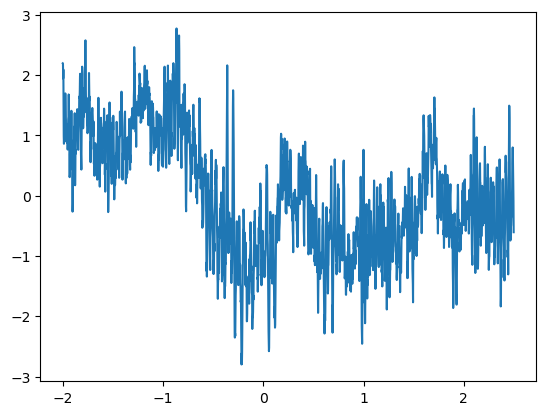

In [327]:
# Zscore the data first (idk why, but otherwise unable to plot IMFs) 

test_epoch = zscore(epochs_all_subjs_all_evs[subj_id][event]._data[0, 26, :])
time_vect = epochs_all_subjs_all_evs[subj_id][event].times
sample_rate = int(epochs_all_subjs_all_evs[subj_id][event].info['sfreq'])
plt.plot(time_vect, test_epoch)

<AxesSubplot:xlabel='Time (samples)'>

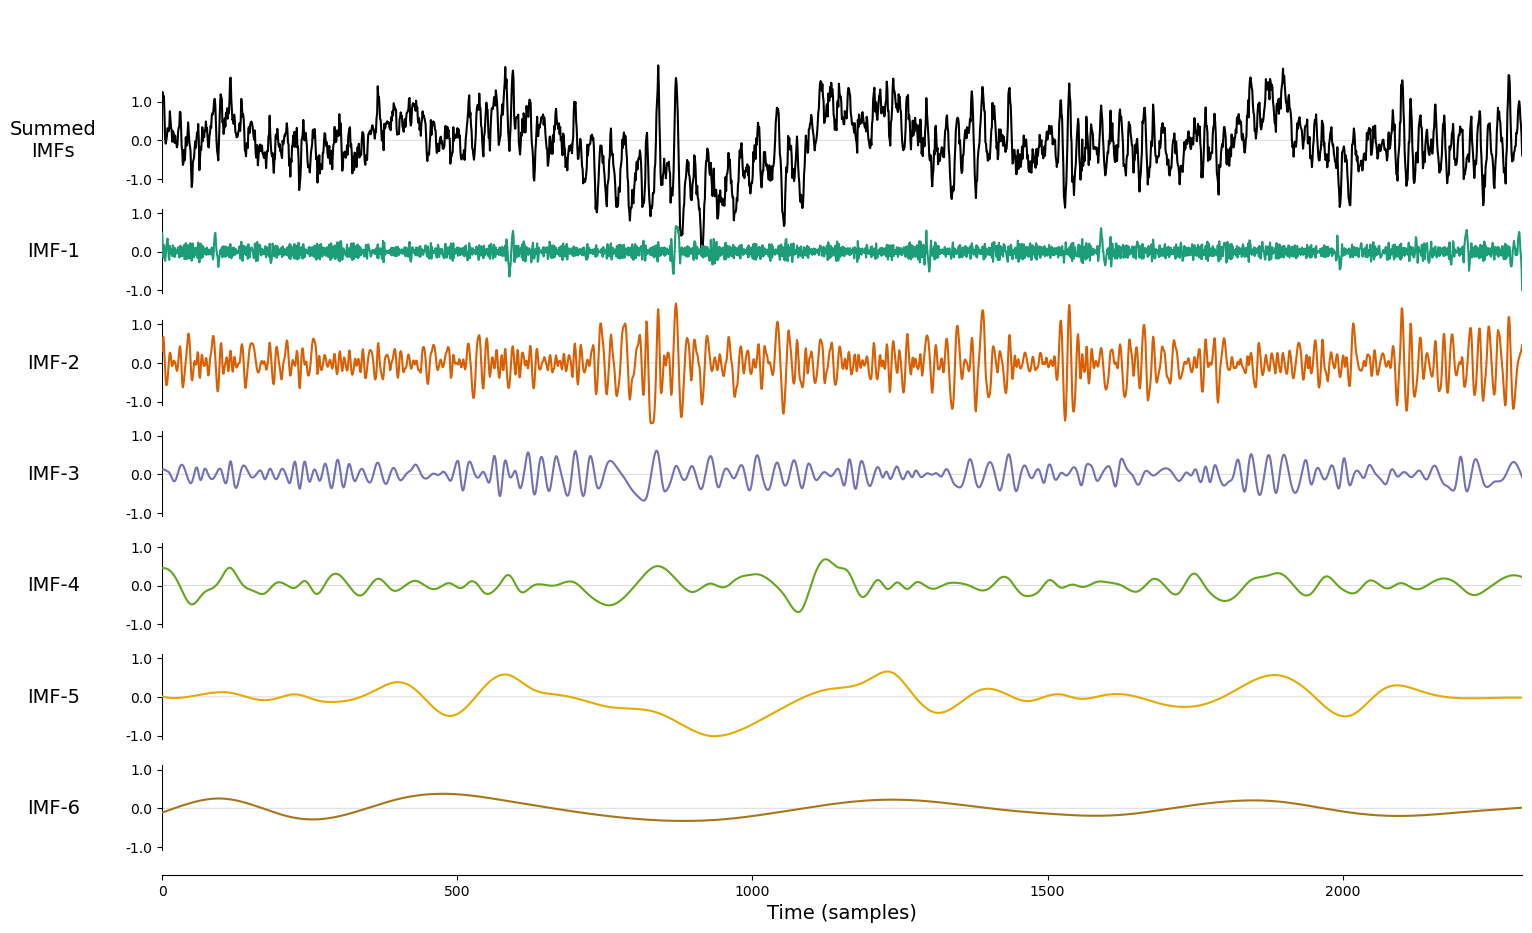

In [328]:
imf = emd.sift.sift(test_epoch, max_imfs=6)
# Visualise the IMFs
emd.plotting.plot_imfs(imf)

Here, it looks like IMF-2 might have some meaningful oscillatory bursts in it

from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method

In [334]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

# ``all_cycles`` is an array of the same size as the input instantaneous phase.
# Each row contains a vector of itegers indexing the location of successive
# cycles for that IMF.

# Set a 33% amplitude threshold on IMF-1 

thresh = np.percentile(IA[:, 1], 33)
mask = IA[:, 1] > thresh

mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

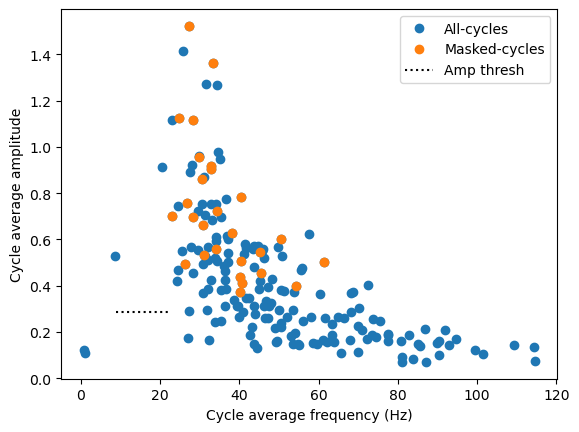

In [335]:

# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 1], IA[:, 1], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IA[:, 1], func=np.mean)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
plt.plot((9, 22), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

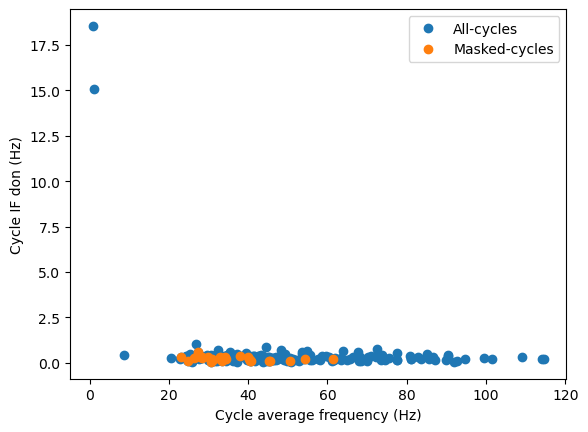

In [336]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)


# Define a simple function to compute the range of a set of values
def degree_nonlinearity(x):
    return np.std((x - x.mean()) / x.mean())


# Compute cycle freuquency range for all cycles and for masked cycles
all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1],
                                               func=degree_nonlinearity)
cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1],
                                           func=degree_nonlinearity)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle IF don (Hz)')
plt.legend(['All-cycles', 'Masked-cycles'])

In [337]:
C = emd.cycles.Cycles(IP[:, 1])


In [345]:
C.compute_cycle_metric('max_amp', IA[:, 1], func=np.max)
# Compute the length of each cycle
C.compute_cycle_metric('duration', IA[:, 1], len)


In [347]:
df = C.get_metric_dataframe()
print(df)

     is_good   max_amp  duration
0          0  0.712878        12
1          0  0.408407         7
2          0  0.340272         9
3          0  0.632888        12
4          0  0.762989        17
..       ...       ...       ...
183        1  1.036988        16
184        1  0.985259        17
185        0  1.232302        18
186        1  1.261188        18
187        0  0.631540         8

[188 rows x 3 columns]


(0.0, 60.0)

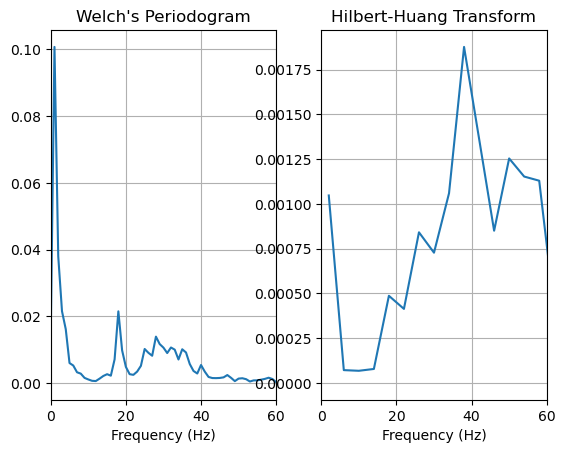

In [364]:
from scipy import signal 
fft_f, pxx_linear = signal.welch(test_epoch, fs=sample_rate, nperseg=512)

# Summary figure
plt.figure()
plt.subplot(121)
plt.plot(fft_f, pxx_linear)
plt.title("Welch's Periodogram")
# plt.xlim(0, 20)
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.xlabel('Frequency (Hz)')

# Hilbert-Huang transform
freq_range = (0, 256, 64)
hht_f, spec_linear = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density', sum_imfs=False)

plt.xlim(0, 60)
plt.subplot(122)
plt.plot(hht_f, spec_linear[:, 0])
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.title("Hilbert-Huang Transform")
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 60)

In [355]:
fft_f.shape

(257,)

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:



In [195]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 30, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

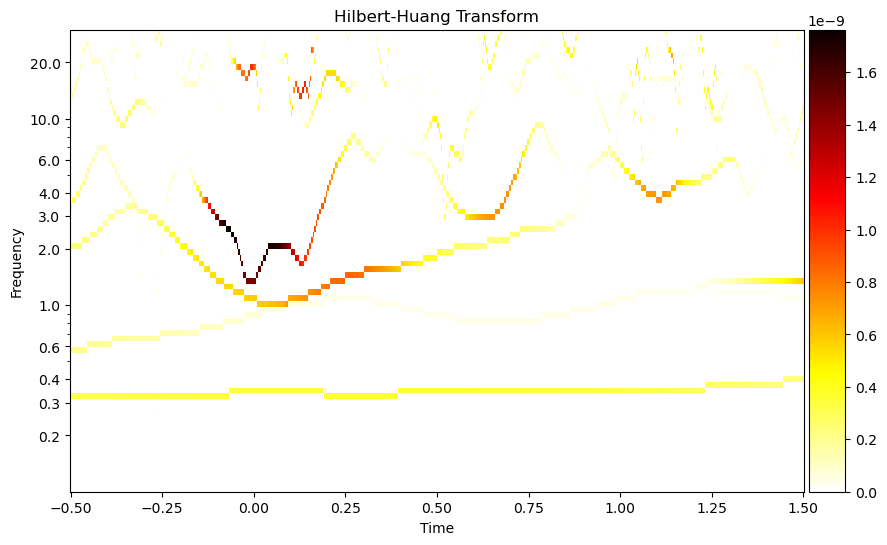

In [199]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               time_lims=(-0.5, 1.5), freq_lims=(0.1, 30),
                               fig=fig, log_y=True)

## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first


Use the metadata to assign conditions to parse your epochs!

In [364]:
subj_id = 'MS025'
# analysis_evs = ['feedback_start']
analysis_ev = 'feedback_start'
baseline_ev = 'baseline_start'
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

In [469]:
# power parameters 
freqs = np.logspace(*np.log10([4, 120]), num=20)
n_cycles = 4  
sr = epochs_all_subjs_all_evs[subj_id][analysis_ev].info['sfreq']
buf = 1.0
buf_ix = int(buf*sr)

baseline_power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

# Compute baseline_power
for subj_id in subj_ids:
    event = 'baseline_start'
    epochs = epochs_all_subjs_all_evs[subj_id][event]
        
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    for ch_ix in np.arange(epochs._data.shape[1]): 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                            freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

    baseline_power_epochs[subj_id][event] = temp_pow

for subj_id in subj_ids:
    for event in analysis_evs:
                
        epochs = epochs_all_subjs_all_evs[subj_id][event]
        
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                               epochs._data.shape[1], len(freqs), 
                               epochs._data.shape[-1]])

        for ch_ix in np.arange(epochs._data.shape[1]): 
            ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
            bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
            good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs, axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                                epochs.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
                                      baseline_power_epochs[subj_id]['baseline_start'], mode='zscore', baseline_only=False)
        
        zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = epochs_all_subjs_all_evs[subj_id][event].metadata
        
        power_epochs[subj_id][event] = zpow

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:136: RuntimeWarning: Mean of empty slice
  data.shape[-1], axis=elec_axis)
/sc/arion/work/qasims01/test-env/envs/LFPAnalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [470]:
power_epochs['MS025']['feedback_start'].metadata

,lacas1-lacas4,lacas2-lacas4,lacas3-lacas4,lacas6-lacas5,laglt1-laglt5,laglt2-laglt5,laglt3-laglt5,laglt7-lhplt6,laglt8-lhplt7,laglt9-lhplt8,...,rpvnh1-rcmip8,rpvnh11-rpvnh9,rpvnh2-rcmip8,rpvnh3-rcmip7,rpvnh4-rcmip8,rpvnh5-rpvnh8,rt,reward,image_dprime,rpe
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,16.255064,1.0,2.337818,0.500000
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,4.730283,0.0,1.975903,-0.775057
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,4.093465,1.0,1.726771,0.651313
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,4.179714,0.0,1.675859,-0.500000
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,1.786383,1.0,1.953028,0.293016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,0.616090,1.0,2.042671,0.804742
76,None,None,None,None,[368],None,[365],None,None,None,...,None,None,None,None,None,None,0.456772,1.0,1.664885,0.362042
77,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,0.412324,0.0,3.306850,-0.837123
78,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,2.616740,1.0,1.774710,0.623391


In [471]:
rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']

region = rois[0]

# Get electrode df 
elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
elec_files = glob(f'{elec_path}/*labels.csv')[0]
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'

# Load electrode data (should already be manually localized!)
elec_data = pd.read_csv(elec_files)

# Sometimes there's extra columns with no entries: 
elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]

if 'NMMlabel' in elec_data.keys(): 
    # This is an annoying naming convention but also totally my fault lol
    elec_data.rename(columns={'NMMlabel':'label'}, inplace=True)
        
elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names

picks = analysis_utils.select_picks_rois(elec_df, region)

/tmp/ipykernel_105669/651936950.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names


In [472]:
times = power_epochs['MS025']['feedback_start'].times
yticks = [4, 8, 13, 30, 60, 120]

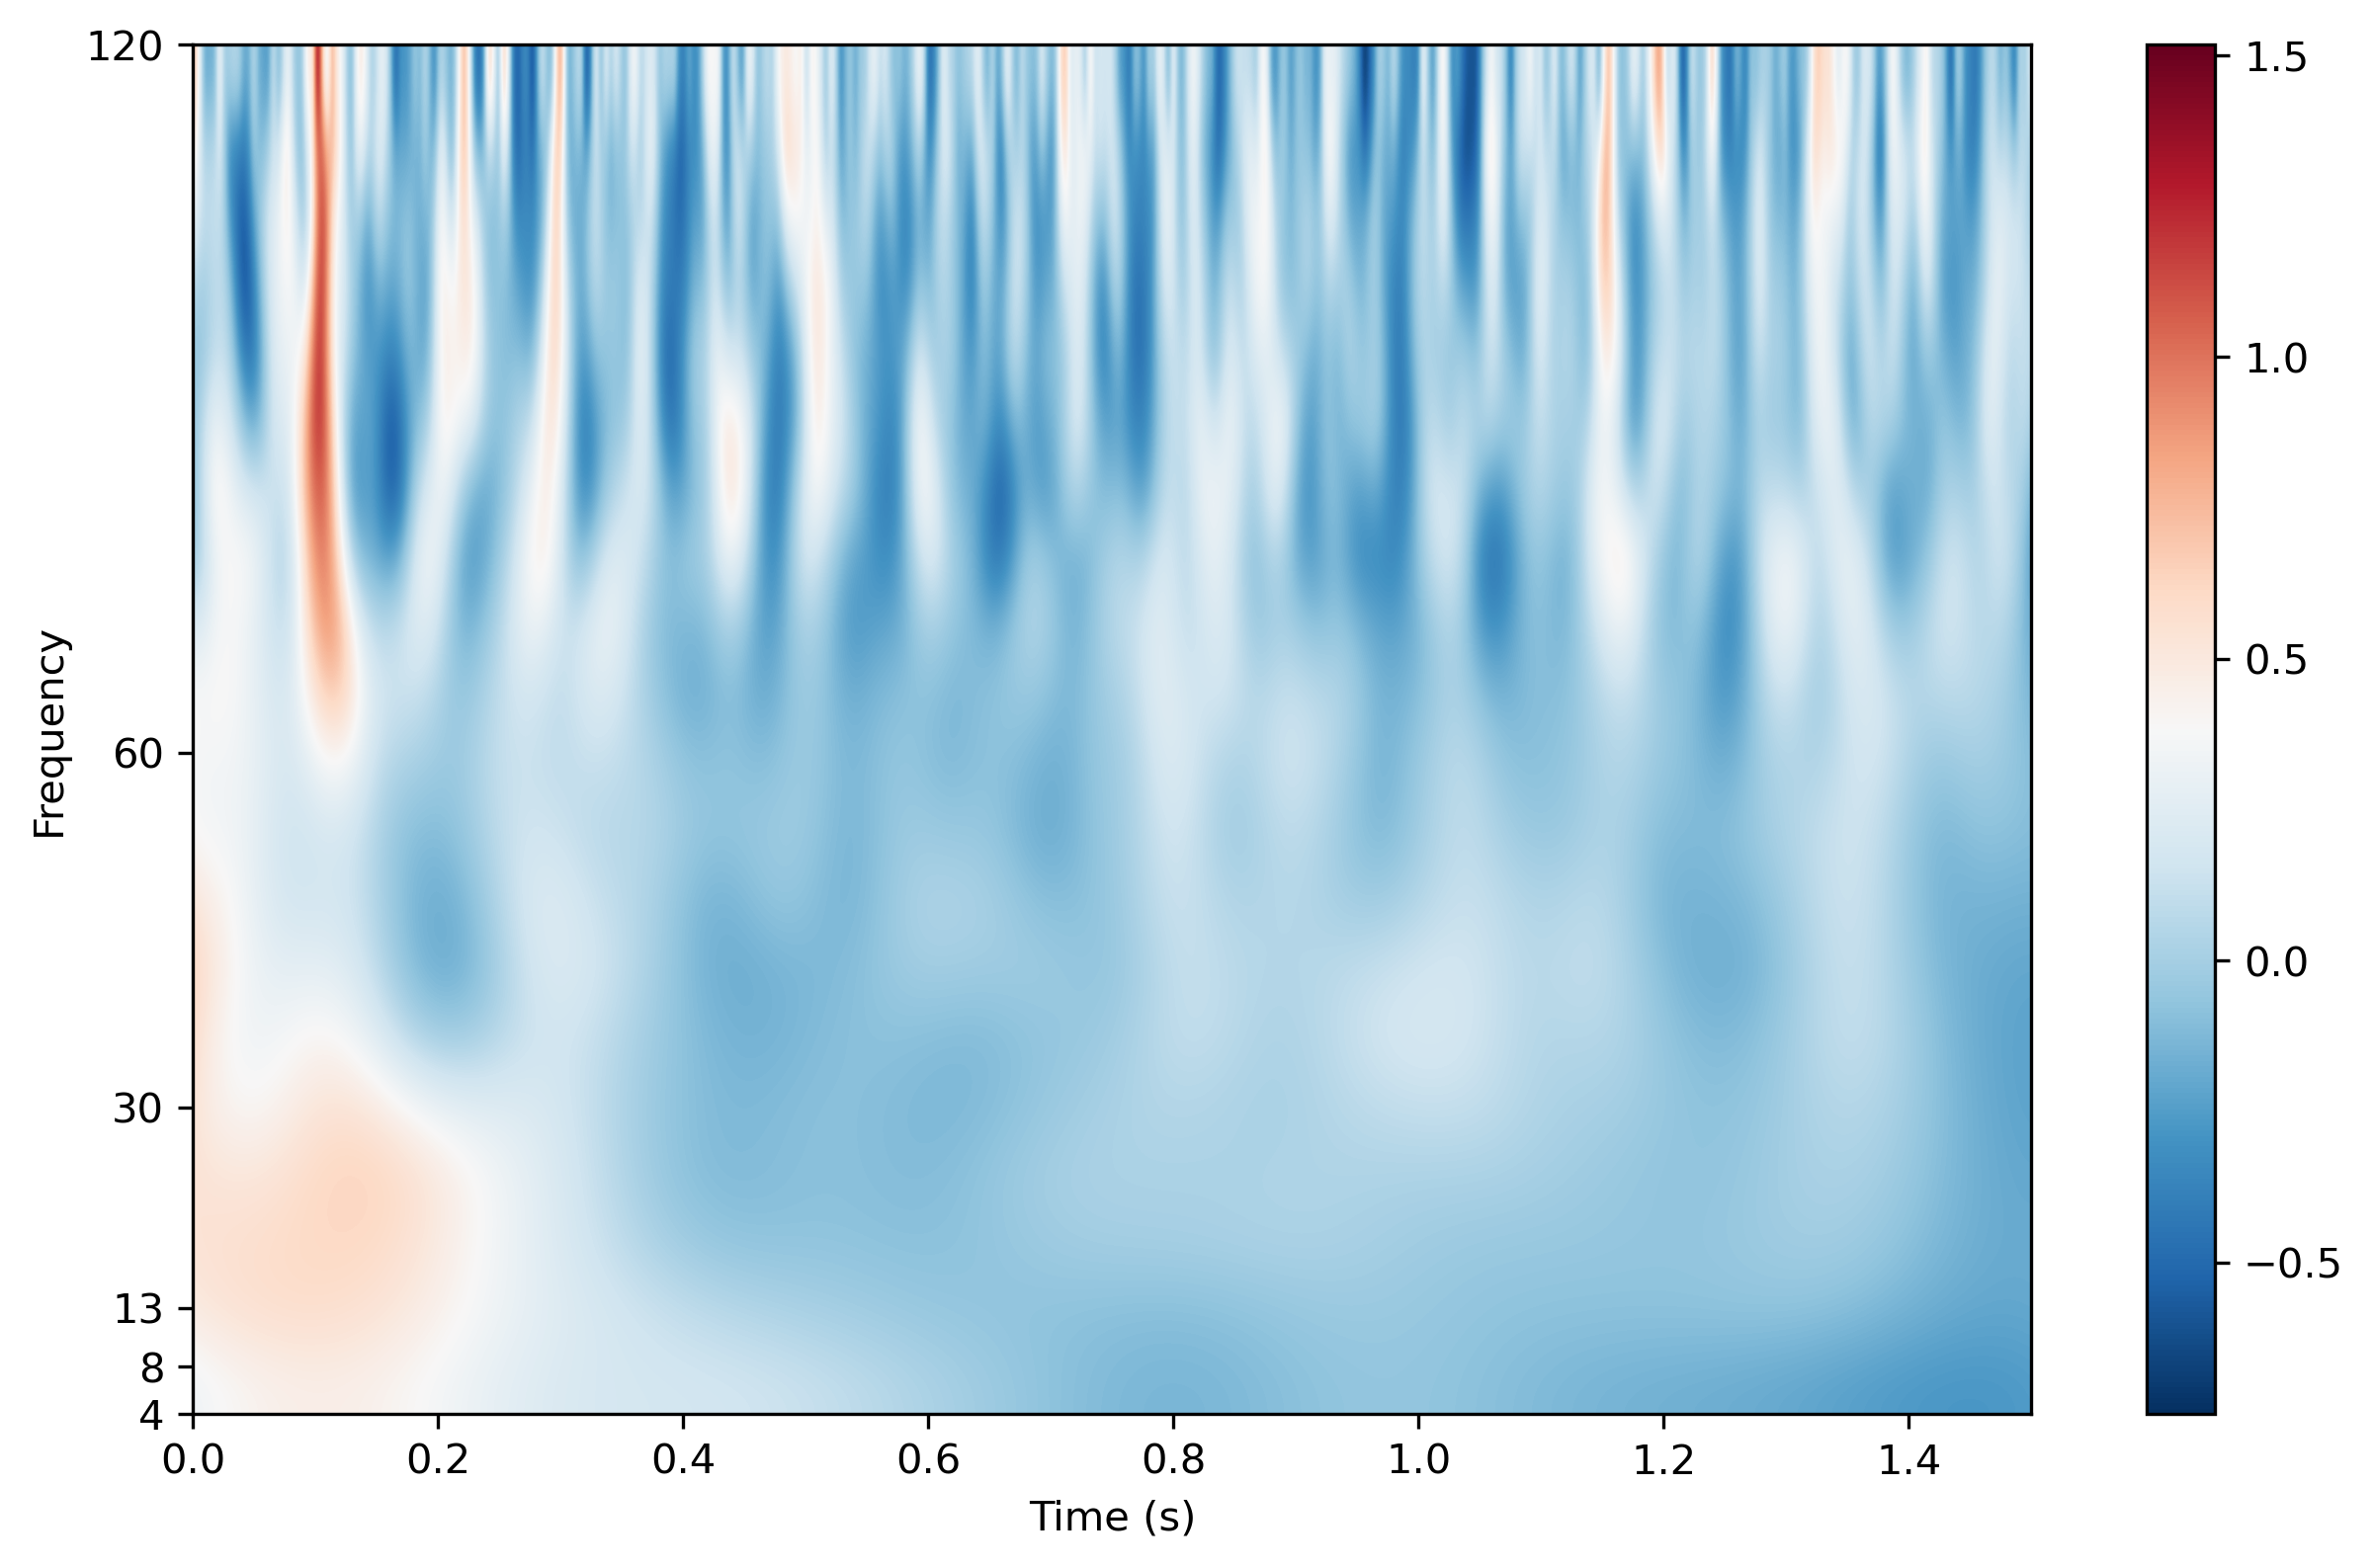

In [473]:

plot_data = np.nanmean(np.nanmean(power_epochs['MS025']['feedback_start']['reward==1'].copy().pick_channels(picks).data, axis=0), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
im = ax.imshow(plot_data,
          extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
          aspect='auto', origin='lower', cmap='RdBu_r', vmin = np.nanmin(plot_data), vmax = np.nanmax(plot_data))
ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency')
fig.colorbar(im, ax=ax)


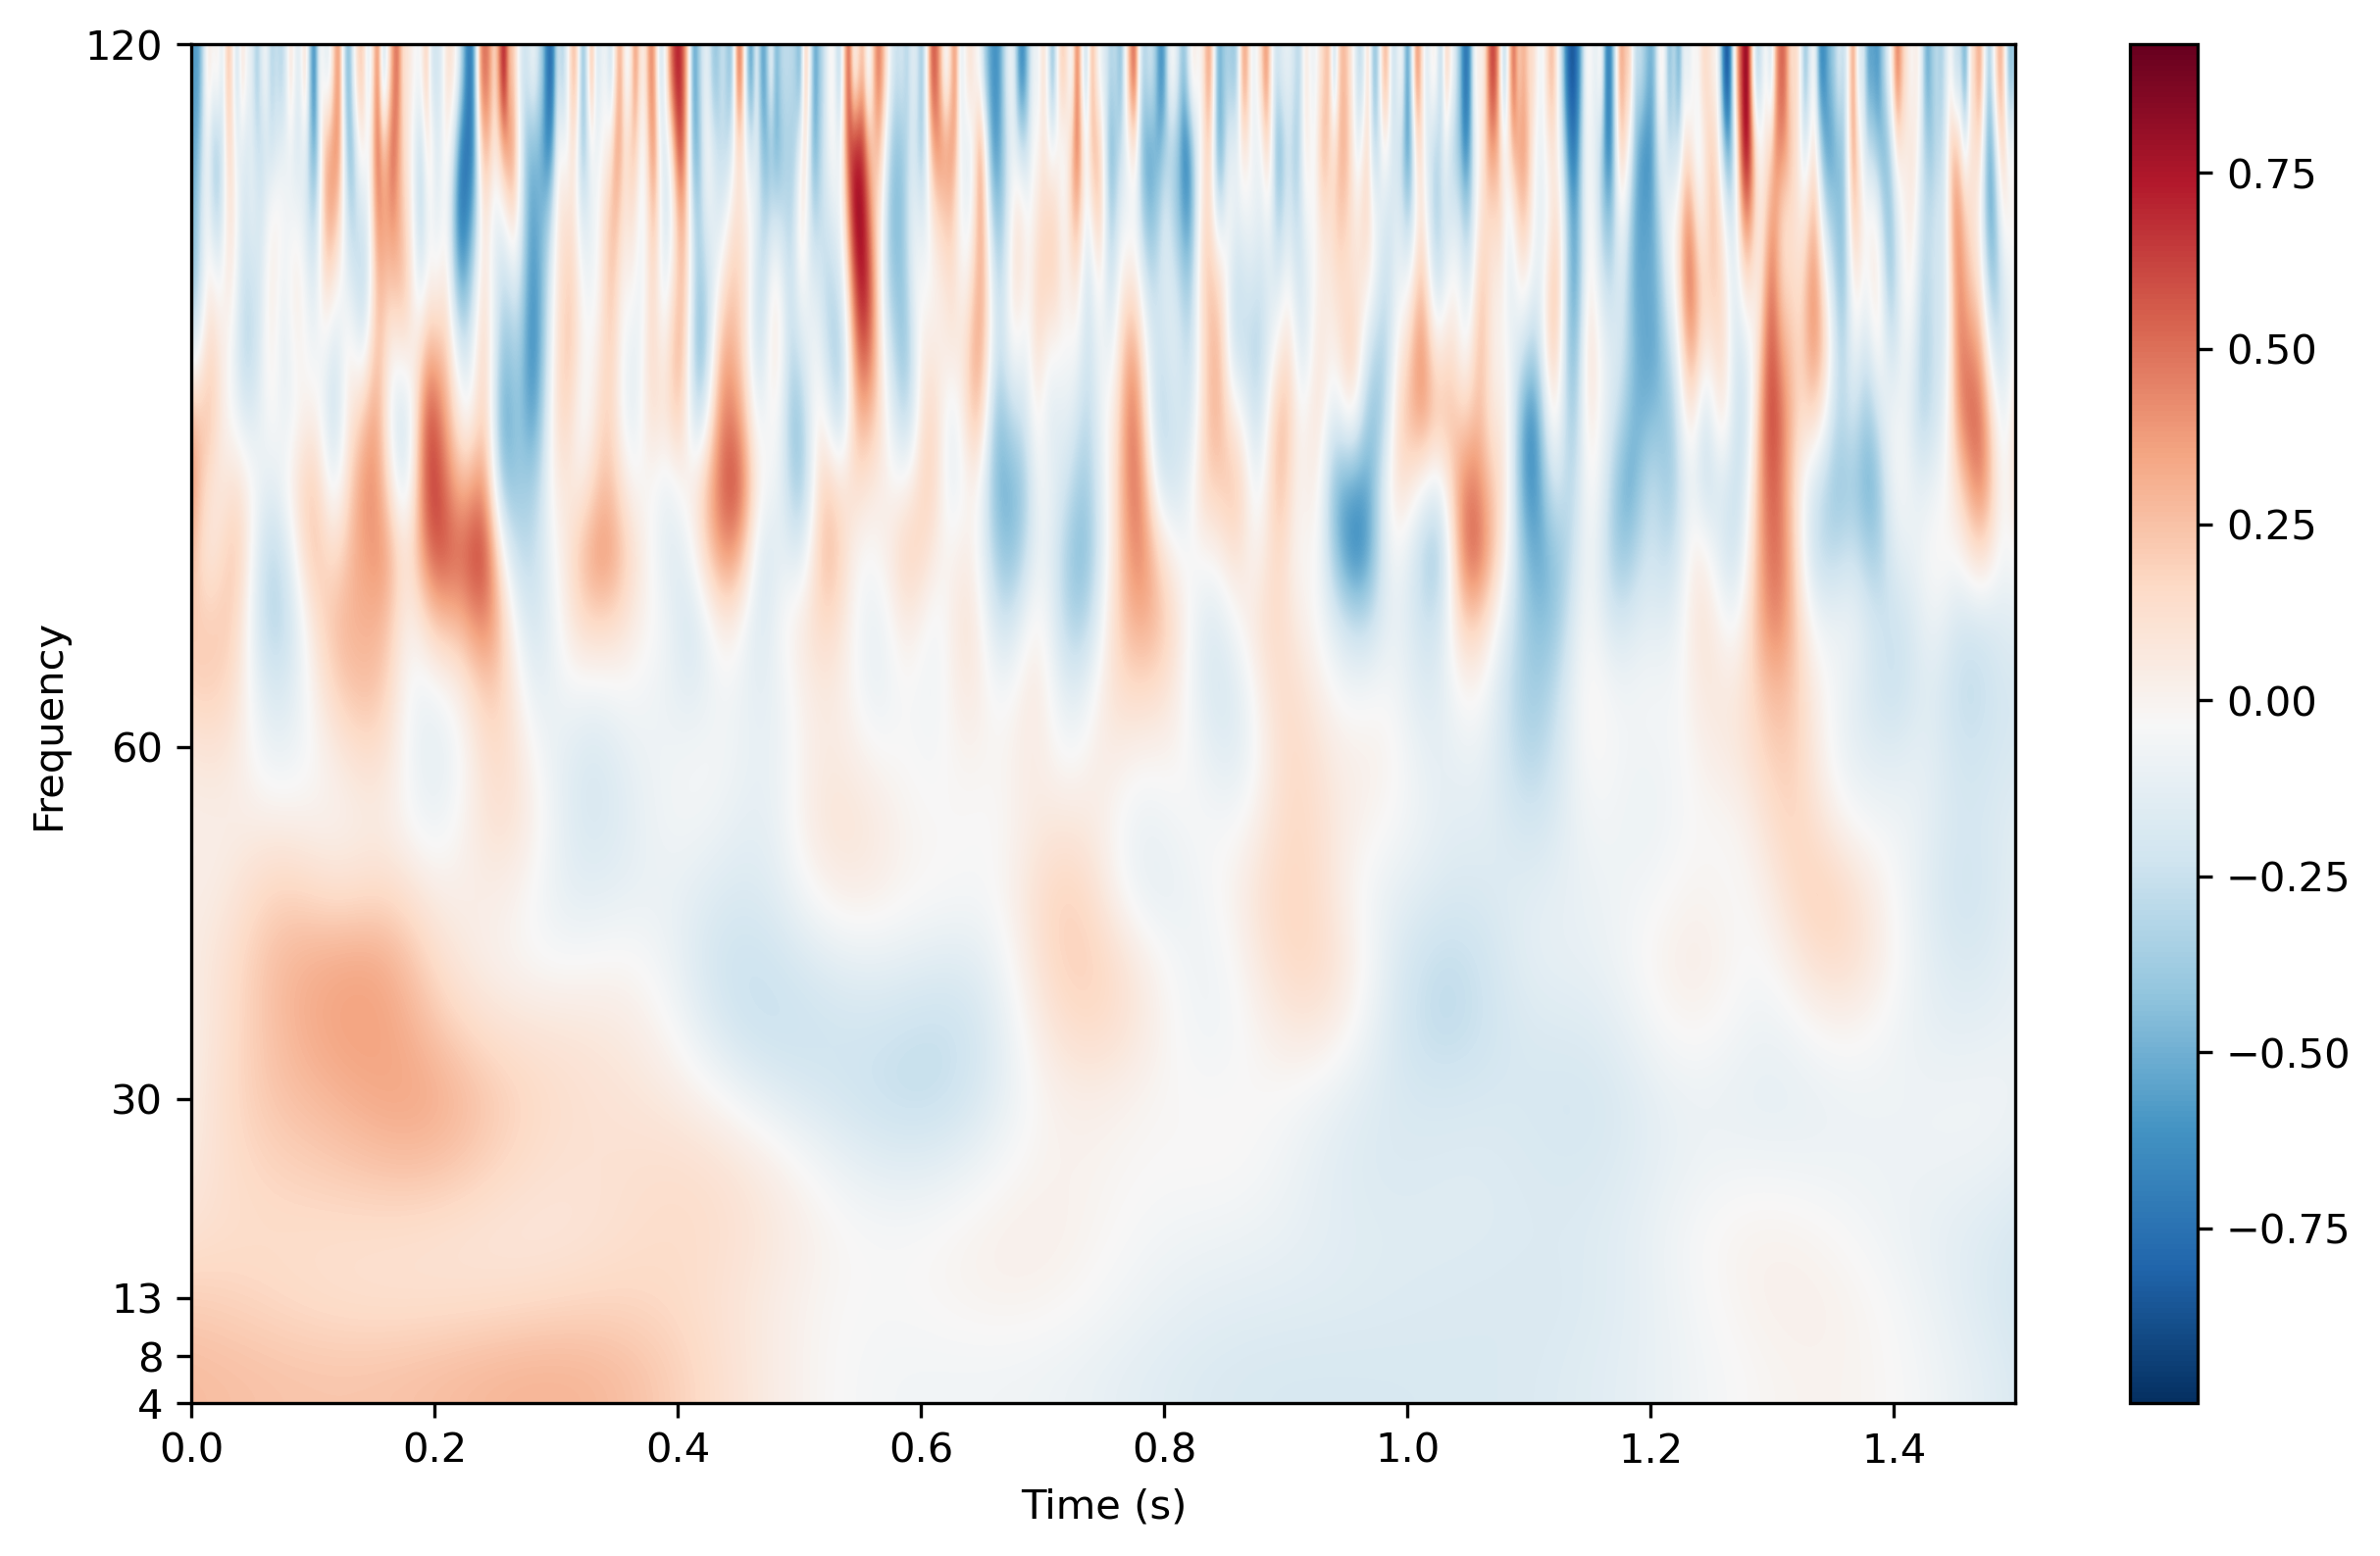

In [474]:
plot_data = np.nanmean(np.nanmean(power_epochs['MS025']['feedback_start']['reward==0'].copy().pick_channels(picks).data, axis=0), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
im = ax.imshow(plot_data,
          extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
          aspect='auto', origin='lower', cmap='RdBu_r', vmin = np.nanmin(plot_data), vmax = np.nanmax(plot_data))
ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency')
fig.colorbar(im, ax=ax)


In [413]:
plot_data.min()

-1.0464042394701217e-07

In [239]:
power_epochs['MS025']['feedback_start']['reward==0'].copy().pick_channels(picks).data[power_epochs['MS025']['feedback_start']['reward==0'].copy().pick_channels(picks).data>5].shape



(67620,)

In [205]:
plot_data.min()

1410008.1754922175

## Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

As an example, let's say I want to compare the reward vs. no-reward conditions for every channel, and identify the timepoints and frequencies that exhibit significant differences between conditions. To do so, I would utilize a non-parametric cluster-permutation test.

In [ ]:
for label in diff_pow_epochs[parsing].ch_names[0:1]: 
    region_label = elec_df[elec_df.label==label].YBA_1.values[0]
    if region_label == 'Unknown':
        region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

    plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
    
    rdata = diff_pow_epochs['reward==1'].data[:, plot_ix, :, :]
    nrdata = diff_pow_epochs['reward==0'].data[:, plot_ix, :, :]

for label in diff_pow_epochs[parsing].ch_names: 
    region_label = elec_df[elec_df.label==label].YBA_1.values[0]
    if region_label == 'Unknown':
        region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

    plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
    
    rdata = diff_pow_epochs['reward==1'].data[:, plot_ix, :, :]
    rdata = rdata[np.unique(np.where(~np.isnan(rdata))[0]), :, :]
    nrdata = diff_pow_epochs['reward==0'].data[:, plot_ix, :, :]
    nrdata = nrdata[np.unique(np.where(~np.isnan(nrdata))[0]), :, :]
        
    X = [rdata, 
         nrdata]
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_test(X, n_permutations=1000, out_type='mask', 
                                       verbose=True)
    
    if any(cluster_p_values<=0.05):
        print(region_label)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        times = diff_pow_epochs['reward==0'].times

        evoked_power_1 = np.nanmean(X[0], axis=0)
        evoked_power_2 = np.nanmean(X[1], axis=0)
        evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power_contrast)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Frequency (Hz)')
        # # ax.set_title(f'Induced power ({ch_name})')
    
    